In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Conv2D, Flatten, Conv2DTranspose, Reshape, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from scipy.stats import norm

In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# data load
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)
print(x_tr.shape, x_te.shape)
print(x_tr_flat.shape, x_te_flat.shape)

# network parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2

(60000, 28, 28) (10000, 28, 28)
(60000, 784) (10000, 784)


In [4]:
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps

In [5]:
# encoder
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat)
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)

mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])

encoder_flat = Model(inputs_flat, [mu_flat, log_var_flat, z_flat], name='encoder_conv')

In [6]:
# decoder
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)

In [7]:
# encoder Conv2D
inputs = Input(shape=(28, 28, 1))
x = inputs
x_encoded = Conv2D(32, 5, activation="relu", strides=2, padding="same")(x)
x_encoded = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x_encoded)
x_encoded = Flatten()(x_encoded)
x_encoded = Dense(16, activation="relu")(x_encoded)
mu = Dense(z_dim)(x_encoded)
log_var = Dense(z_dim)(x_encoded)
z = Lambda(sampling, output_shape=(z_dim,))([mu, log_var])

encoder_conv = Model(inputs, [mu, log_var, z], name='encoder_conv')

In [8]:
# decoder Conv2D
latent_inputs = Input(shape=(z_dim,))
y = Dense(7 * 7 * 64, activation="relu")(latent_inputs)
y = Reshape((7, 7, 64))(y)
y = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(y)
y = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(y)
y = Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(y)

decoder_conv = Model(latent_inputs, y, name="decoder_conv")
outputs = decoder_conv(z)

In [9]:
# loss flat VAE
reconstruction_loss = losses.binary_crossentropy(inputs_flat,
                                                 outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat - 1, axis = -1)
vae_flat_loss = reconstruction_loss + kl_loss

# build model
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer='adam')

In [10]:
# loss Conv2D VAE
reconstruction_loss = losses.binary_crossentropy(K.flatten(inputs),
                                                 K.flatten(outputs)) 

reconstruction_loss *= 28 * 28
kl_loss = 1 + log_var - K.square(mu) - K.exp(log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_conv_loss = K.mean(reconstruction_loss + kl_loss)

# build model
vae_conv = Model(inputs, outputs)
vae_conv.add_loss(vae_conv_loss)
vae_conv.compile(optimizer='adam')
# vae_conv.summary()

In [11]:
# train
vae_flat.fit(x_tr_flat,
           shuffle=True,
           epochs=n_epoch,
           batch_size=batch_size,
           validation_data=(x_te_flat, None), verbose=1)

Epoch 1/50
600/600 [==============================] - 3s 4ms/step - loss: 194.8678 - val_loss: 171.9766
Epoch 2/50
600/600 [==============================] - 2s 4ms/step - loss: 166.8963 - val_loss: 162.7179
Epoch 3/50
600/600 [==============================] - 2s 4ms/step - loss: 159.8341 - val_loss: 157.7646
Epoch 4/50
600/600 [==============================] - 2s 4ms/step - loss: 155.7495 - val_loss: 154.4942
Epoch 5/50
600/600 [==============================] - 2s 4ms/step - loss: 152.8158 - val_loss: 151.9652
Epoch 6/50
600/600 [==============================] - 2s 4ms/step - loss: 150.4653 - val_loss: 149.8647
Epoch 7/50
600/600 [==============================] - 2s 4ms/step - loss: 148.5968 - val_loss: 148.4552
Epoch 8/50
600/600 [==============================] - 2s 4ms/step - loss: 147.0478 - val_loss: 146.8960
Epoch 9/50
600/600 [==============================] - 3s 4ms/step - loss: 145.8374 - val_loss: 146.3558
Epoch 10/50
600/600 [==============================] - 2s 4ms/st

In [12]:
# train
vae_conv.fit(x_tr,
       shuffle=True,
       epochs=n_epoch,
       batch_size=batch_size,
       validation_data=(x_te, None), verbose=1)

Epoch 1/50
600/600 [==============================] - 6s 7ms/step - loss: 213.1656 - val_loss: 195.6572
Epoch 2/50
600/600 [==============================] - 4s 7ms/step - loss: 187.7433 - val_loss: 181.1666
Epoch 3/50
600/600 [==============================] - 4s 7ms/step - loss: 178.4012 - val_loss: 175.4092
Epoch 4/50
600/600 [==============================] - 4s 7ms/step - loss: 173.1977 - val_loss: 171.1339
Epoch 5/50
600/600 [==============================] - 4s 7ms/step - loss: 168.8835 - val_loss: 167.9755
Epoch 6/50
600/600 [==============================] - 4s 7ms/step - loss: 163.9410 - val_loss: 158.5670
Epoch 7/50
600/600 [==============================] - 4s 7ms/step - loss: 156.8627 - val_loss: 154.6210
Epoch 8/50
600/600 [==============================] - 4s 7ms/step - loss: 153.5466 - val_loss: 152.6148
Epoch 9/50
600/600 [==============================] - 4s 7ms/step - loss: 151.4960 - val_loss: 150.7948
Epoch 10/50
600/600 [==============================] - 4s 7ms/st

In [13]:
# build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat
encoder_c = Model(inputs, z)            # conv

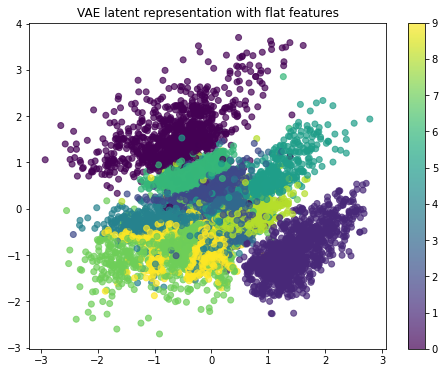

In [14]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f.predict(x_te_flat, batch_size=batch_size)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.7)
plt.title('VAE latent representation with flat features')
plt.colorbar()
plt.savefig('imgs/latent_VAE_flat.png')
plt.show()

(10000, 2)


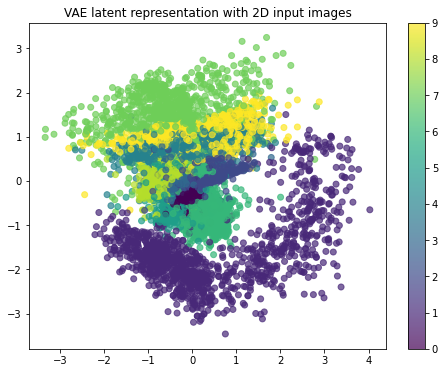

In [15]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_c.predict(x_te, batch_size=batch_size)
print(x_te_latent.shape)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.7)
plt.title('VAE latent representation with 2D input images')
plt.colorbar()
plt.savefig('imgs/latent_VAE_CNN.png')
plt.show()

### Visualize Learnt Representations

In [16]:
generator = decoder_flat

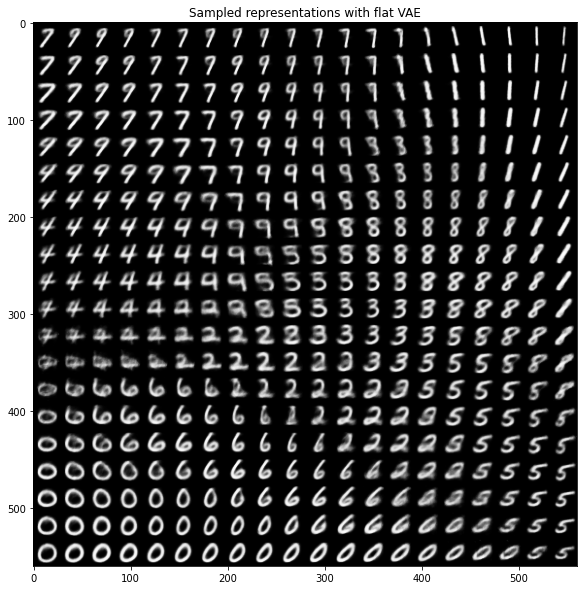

In [17]:
# display a 2D manifold of the digits
n = 20 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('Sampled representations with flat VAE')
plt.imshow(figure, cmap='Greys_r')
plt.savefig('imgs/repr_VAE_flat.png')
plt.show()

In [18]:
generator = decoder_conv

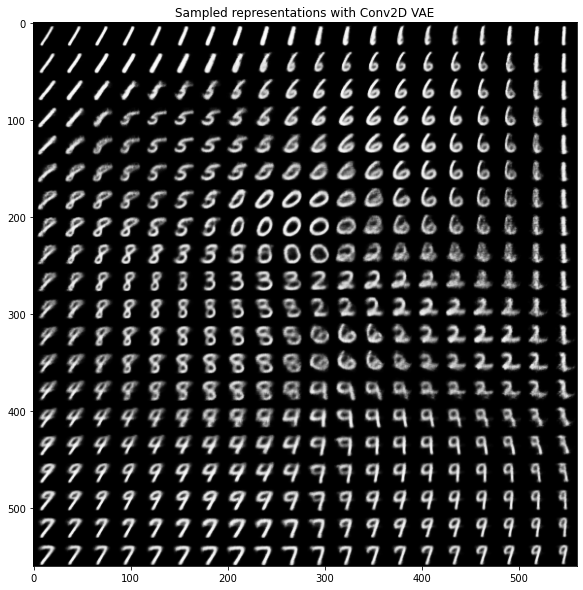

In [19]:
# display a 2D manifold of the digits
n = 20 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('Sampled representations with Conv2D VAE')
plt.imshow(figure, cmap='Greys_r')
plt.savefig('imgs/repr_VAE_CNN.png')
plt.show()

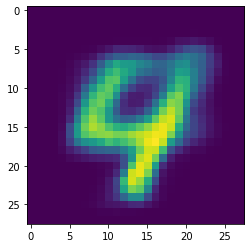

In [20]:
z_sample = np.array([[-0.35, 0.75]])
x_decoded = generator.predict(z_sample)
digit = x_decoded[0].reshape(digit_size, digit_size)
plt.imshow(digit);

### NN classifiers
Analyze learnt representations from Neural Network Classifiers

In [21]:
# decoder_flat.trainable = False
# decoder_conv.trainable = False

In [22]:
current_epoch = 1
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global current_epoch
        current_epoch += 1
        
    def on_train_batch_end(self, batch, logs=None):
        keys = list(logs.keys())
        x_te_latent = encoder.predict(x_te_flat, batch_size=64)
        plt.figure(figsize=(8, 6))
        plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.6)
        plt.title(f'Batch: {batch}')
        plt.colorbar(); plt.savefig(f"imgs/learnt_representation/img_{current_epoch}_{batch:0>3}.png")
        print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

In [23]:
inputs_flat_2 = Input(shape=(x_tr_flat.shape[1:]))
res = Dense(256, activation='relu')(inputs_flat_2)
res = Dense(128, activation='relu')(res)
res = Dense(32, activation='relu')(res)
z_nn = Dense(2, activation='linear')(res)
res = Dense(16, activation='relu')(z_nn)
class_outputs = Dense(10, activation='softmax')(res)
classifier = Model(inputs_flat_2, class_outputs)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

encoder = Model(inputs_flat_2, z_nn)

classifier.fit(x_tr_flat, to_categorical(y_tr), epochs=15, batch_size=128, #batch_size, 
               validation_split=0.15, shuffle=True,) # callbacks=[CustomCallback()]) # save latent representations

Epoch 1/15
399/399 [==============================] - 2s 4ms/step - loss: 0.8290 - accuracy: 0.7165 - val_loss: 0.3583 - val_accuracy: 0.9104
Epoch 2/15
399/399 [==============================] - 1s 4ms/step - loss: 0.3086 - accuracy: 0.9194 - val_loss: 0.2292 - val_accuracy: 0.9430
Epoch 3/15
399/399 [==============================] - 1s 4ms/step - loss: 0.2034 - accuracy: 0.9456 - val_loss: 0.1889 - val_accuracy: 0.9523
Epoch 4/15
399/399 [==============================] - 1s 4ms/step - loss: 0.1471 - accuracy: 0.9608 - val_loss: 0.1755 - val_accuracy: 0.9572
Epoch 5/15
399/399 [==============================] - 1s 4ms/step - loss: 0.1152 - accuracy: 0.9693 - val_loss: 0.1635 - val_accuracy: 0.9628
Epoch 6/15
399/399 [==============================] - 1s 4ms/step - loss: 0.0898 - accuracy: 0.9764 - val_loss: 0.1787 - val_accuracy: 0.9583
Epoch 7/15
399/399 [==============================] - 1s 4ms/step - loss: 0.0817 - accuracy: 0.9775 - val_loss: 0.1616 - val_accuracy: 0.9642
Epoch 

In [24]:
classifier.evaluate(x_te_flat, to_categorical(y_te), batch_size=batch_size)

100/100 [==============================] - 0s 2ms/step - loss: 0.1578 - accuracy: 0.9705


[0.15783609449863434, 0.9704999923706055]

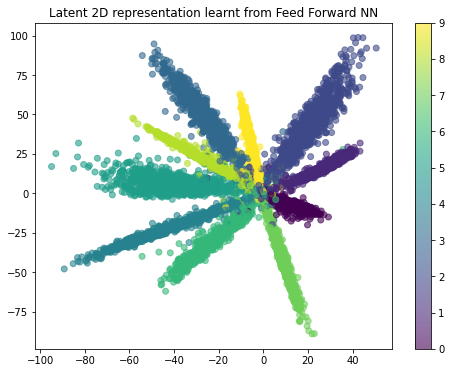

In [25]:
encoder = Model(inputs_flat_2, z_nn)

# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te_flat, batch_size=batch_size)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.6)
plt.title('Latent 2D representation learnt from Feed Forward NN')
plt.colorbar();
plt.savefig('imgs/latent_NN.png') 
plt.show()

In [26]:
inputs_conv_2 = Input(shape=(28, 28, 1))
x_encoded = Conv2D(32, 5, activation="relu", strides=1, padding="same")(inputs_conv_2)
# x_encoded = BatchNormalization()(x_encoded)
x_encoded = MaxPool2D(pool_size = 2, strides = 1)(x_encoded)
x_encoded = Dropout(0.2)(x_encoded)
x_encoded = Conv2D(64, 3, activation="relu", strides=1, padding="same")(x_encoded)
x_encoded = MaxPool2D(pool_size = 2, strides = 1)(x_encoded)
x_encoded = Flatten()(x_encoded)
res = Dense(32, activation='relu')(x_encoded)
res = Dense(16, activation='relu')(res)
z_cnn = Dense(2, activation='linear')(res)
res = Dense(16, activation='relu')(z_cnn)
class_outputs = Dense(10, activation='softmax')(res)
classifier = Model(inputs_conv_2, class_outputs)
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x_tr, to_categorical(y_tr), epochs=20, batch_size=batch_size, validation_split=0.15, shuffle=True)

Epoch 1/20
510/510 [==============================] - 5s 9ms/step - loss: 0.6157 - accuracy: 0.7884 - val_loss: 0.2259 - val_accuracy: 0.9371
Epoch 2/20
510/510 [==============================] - 4s 8ms/step - loss: 0.1956 - accuracy: 0.9464 - val_loss: 0.1396 - val_accuracy: 0.9619
Epoch 3/20
510/510 [==============================] - 4s 8ms/step - loss: 0.1415 - accuracy: 0.9609 - val_loss: 0.1127 - val_accuracy: 0.9694
Epoch 4/20
510/510 [==============================] - 4s 8ms/step - loss: 0.1140 - accuracy: 0.9682 - val_loss: 0.1010 - val_accuracy: 0.9742
Epoch 5/20
510/510 [==============================] - 4s 8ms/step - loss: 0.0957 - accuracy: 0.9733 - val_loss: 0.0892 - val_accuracy: 0.9767
Epoch 6/20
510/510 [==============================] - 4s 8ms/step - loss: 0.0794 - accuracy: 0.9778 - val_loss: 0.0789 - val_accuracy: 0.9806
Epoch 7/20
510/510 [==============================] - 4s 8ms/step - loss: 0.0746 - accuracy: 0.9793 - val_loss: 0.0795 - val_accuracy: 0.9803
Epoch 

In [27]:
classifier.evaluate(x_te, to_categorical(y_te), batch_size=batch_size)

100/100 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.98 - 0s 3ms/step - loss: 0.0694 - accuracy: 0.9842


[0.06940391659736633, 0.9842000007629395]

(10000, 2)


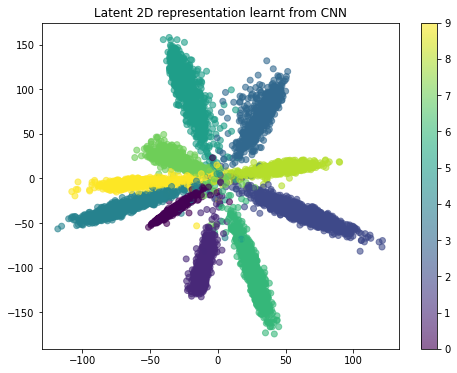

In [42]:
encoder = Model(inputs_conv_2, z_cnn)

# Plot of the digit classes in the latent space
x_te_latent = encoder.predict(x_te, batch_size=batch_size)
print(x_te_latent.shape)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.6)
plt.title('Latent 2D representation learnt from CNN')
plt.colorbar();
plt.savefig('imgs/latent_CNN.png') 
plt.show()

### Linear dimensionality reductions

In [29]:
from sklearn.decomposition import PCA

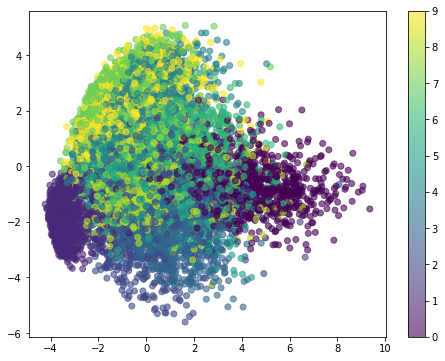

In [30]:
pca = PCA(n_components=2)
pca.fit(x_tr_flat)
x_te_pca = pca.transform(x_te_flat)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_pca[:, 0], x_te_pca[:, 1], c=y_te, alpha=0.6)
plt.colorbar()
plt.savefig('imgs/pca.png')
plt.show()

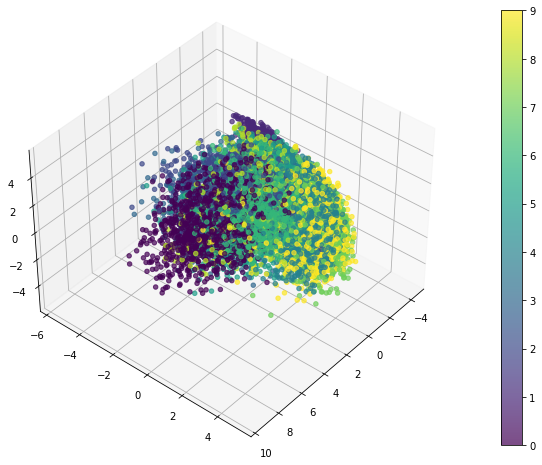

In [31]:
pca = PCA(n_components=3)
pca.fit(x_tr_flat)
x_te_pca = pca.transform(x_te_flat)
fig = plt.figure(figsize=(20, 8))
ax = plt.axes(projection='3d')
ax.view_init(40, 40)
p = ax.scatter(x_te_pca[:, 0], x_te_pca[:, 1],x_te_pca[:, 2], c=y_te, alpha=0.7)
plt.colorbar(p)
plt.savefig('imgs/pca-3d.png')
plt.show()

In [32]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

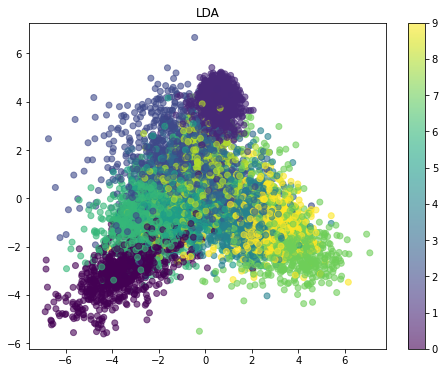

In [33]:
lda = LDA(n_components=2)
lda.fit(x_tr_flat, y_tr)
x_te_lda = lda.transform(x_te_flat)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_lda[:, 0], x_te_lda[:, 1], c=y_te, alpha=0.6)
plt.title('LDA'); plt.colorbar(); 
plt.savefig('imgs/lda.png')
plt.show()

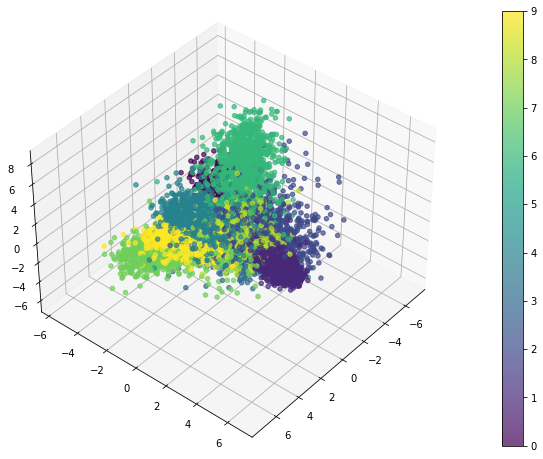

In [34]:
lda = LDA(n_components=3)
lda.fit(x_tr_flat, y_tr)
x_te_lda = lda.transform(x_te_flat)
fig = plt.figure(figsize=(20, 8))
ax = plt.axes(projection='3d')
ax.view_init(40, 40)
p = ax.scatter(x_te_lda[:, 0], x_te_lda[:, 1], x_te_lda[:, 2], c=y_te, alpha=0.7)
plt.colorbar(p); 
plt.savefig('imgs/lda-3d.png')
plt.show()

### Non-linear dimensionality reductions

#### UMAP

In [35]:
import umap
import umap.plot

In [36]:
%%time
mapper = umap.UMAP(random_state=42).fit(x_tr_flat)

C:\Users\gonre\AppData\Roaming\Python\Python39\site-packages\numba\np\ufunc\parallel.py:366: NumbaWarning: The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11100. The TBB threading layer is disabled.
  warnings.warn(problem)


Wall time: 43.2 s


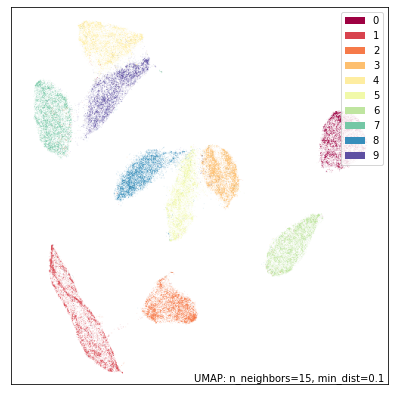

In [37]:
umap.plot.points(mapper, labels=y_tr, width=500, height=500);

In [38]:
embeddings = mapper.transform(x_te_flat)

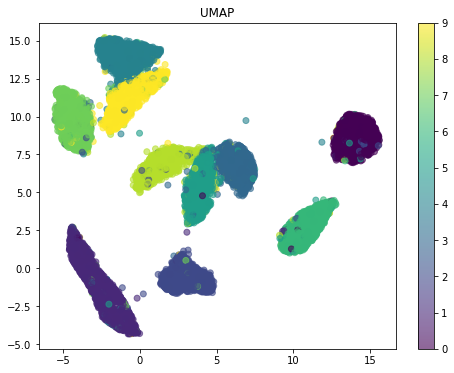

In [39]:
plt.figure(figsize=(8, 6))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y_te, alpha=0.6)
plt.title('UMAP'); plt.colorbar(); 
plt.savefig('imgs/umap.png')
plt.show()

#### t-SNE

In [40]:
from sklearn.manifold import TSNE

C:\Users\gonre\anaconda3\envs\DL_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


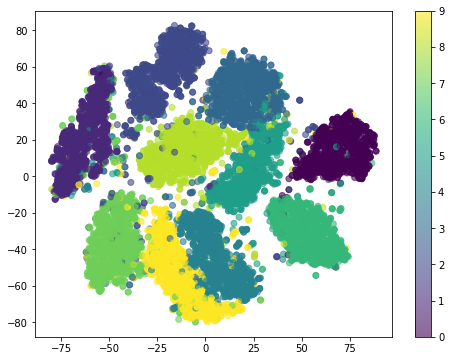

Wall time: 34.3 s


In [41]:
%%time 
t_sne = TSNE(n_components=2, learning_rate='auto', init='pca')
x_te_tsne = t_sne.fit_transform(x_te_flat)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_tsne[:, 0], x_te_tsne[:, 1], c=y_te, alpha=0.6)
plt.colorbar(); 
plt.savefig('imgs/tsne.png')
plt.show()